# Testing the Memory using a toy problem

Problem and inspiration from the excellent [Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/).

This notebook was used during development, and can be run to prove the quality of both the Gaussian Mixture and the LSTM.

## Gaussian mixture with a fully connected head

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

from worldmodels.memory.memory import GaussianMixture, MLP, Memory
from worldmodels.memory.memory import get_pi_idx
from worldmodels.memory.train_memory import train

In [2]:
NSAMPLE = 10000
epochs = 10

y_data = np.random.uniform(-10.5, 10.5, (1, NSAMPLE)).T
r_data = np.random.normal(size=(NSAMPLE,1))
x_data = np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0

num_timesteps = 1
num_features = 1
num_mix = 24
batch_size = NSAMPLE

y_data = y_data.reshape(NSAMPLE, num_timesteps, num_features).astype(np.float32)
x_data = x_data.reshape(NSAMPLE, num_timesteps, num_features).astype(np.float32)

#  this will be the shape of the output of the lstm
#  (batch_size, num_timesteps, output_dim * num_mix * 3)
#  three for one pi, mu, sigma for each mixture
mixture_dim = num_features * num_mix * 3
print(mixture_dim)

72


In [3]:
memory = MLP(num_mix, hidden_nodes=24)

In [4]:
mixture = GaussianMixture(num_features, num_mix, num_timesteps=1, batch_size=batch_size)

In [5]:
x_sample = x_data[0:2]
x_sample.shape

(2, 1, 1)

In [6]:
pi, mu, sigma = mixture(memory(x_data))

In [7]:
x_data[0:2]

array([[[11.468082]],

       [[ 9.803862]]], dtype=float32)

In [8]:
y_data[0:2]

array([[[9.584211]],

       [[9.246455]]], dtype=float32)

In [9]:
def train_op(memory, mixture, x, y):
    with tf.GradientTape() as tape:
        loss = mixture.get_loss(memory(x), y)
        gradients = tape.gradient(loss, memory.trainable_variables)

    optimizer.apply_gradients(zip(gradients, memory.trainable_variables))
    return loss

optimizer = tf.keras.optimizers.Adam()
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(NSAMPLE).batch(batch_size)
loss = np.zeros(epochs)

for epoch in range(epochs):
    for batch in dataset:
        loss[epoch] = train_op(memory, mixture, *batch)
    if epoch % 500 == 1:
        print(epoch, loss[epoch])

1 6.429961681365967


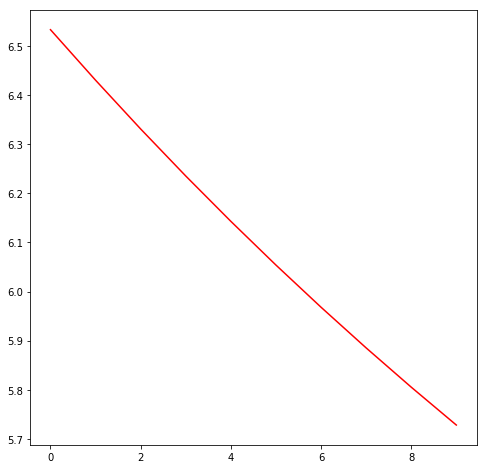

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), loss[:epochs], 'r-')
plt.show()

In [11]:
x_test = np.float32(np.arange(-15,15,0.1))
n_test = x_test.shape[0]
x_test = x_test.reshape(n_test, 1, 1)

In [12]:
mus, sigmas, idxs = np.zeros(n_test), np.zeros(n_test), np.zeros(n_test)
samples = np.zeros(n_test)

for num, sample in enumerate(x_test):
    pi, mu, sigma = mixture(memory(sample.reshape(1, 1, 1)))
    
    pi = np.array(pi).reshape(1, pi.shape[3])
    mu = np.array(mu).reshape(1, mu.shape[3])
    sigma = np.array(sigma).reshape(1, sigma.shape[3])

    idx = get_pi_idx(pi[0], None)
    
    idxs[num] = idx
    mus[num] = mu[:, idx]
    sigmas[num] = sigma[:, idx]
    
    samples[num] = mus[num] + np.random.randn() * sigmas[num]

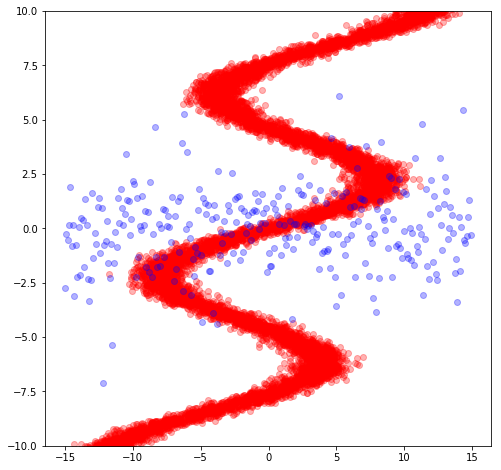

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(samples), 'bo', alpha=0.3)

plt.ylim(-10, 10)
plt.show()

## Gaussian mixture with an LSTM head

In [14]:
memory = Memory(
    input_dim=1, 
    output_dim=num_features, 
    num_timesteps=num_timesteps, 
    batch_size=batch_size, 
    lstm_nodes=24, 
    num_mix=24
)

In [15]:
x = x_data
y = y_data

dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(x.shape[0]).batch(batch_size)
loss = np.zeros(epochs)

for epoch in range(epochs):
    for batch in dataset:
        state = memory.lstm.get_zero_hidden_state(x)
        loss[epoch] = memory.train_op(*batch, state)
    if epoch % 500 == 1:
        print(epoch, loss[epoch])

1 15.482705116271973


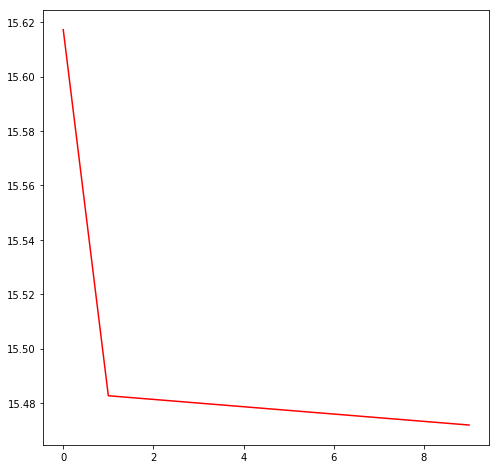

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), loss[:epochs], 'r-')
plt.show()

In [17]:
sample.reshape(1, 1, 1)

array([[[14.9]]], dtype=float32)

In [29]:
sample.shape

(1, 1)

In [34]:
mus, sigmas, idxs = np.zeros(n_test), np.zeros(n_test), np.zeros(n_test)

samples = np.zeros(n_test)
for num, sample in enumerate(x_test):
    latent, _, _ = memory.lstm.net(sample.reshape(1, 1, 1), state)
    pi, mu, sigma = memory.mixture(latent)
    idx = get_pi_idx(pi)
    
    idxs[num] = idx
    mus[num] = mu[:, :, idx]
    sigmas[num] = sigma[:, :, idx]
    
    samples[num] = mus[num] + np.random.randn() * sigmas[num]

ValueError: Tensor's shape (1, 10000, 24) is not compatible with supplied shape [1, 1, 24]

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(np.squeeze(x_data),np.squeeze(y_data), 'ro', np.squeeze(x_test), np.squeeze(samples), 'bo', alpha=0.3)

plt.ylim(-10, 10)
plt.show()